In [127]:
# papermill parameters
zona = 39
class_label="Class_label_Jenks"
ruta = "/Volumes/Juanjo_4TB/Disco_4T/Master_Inteligencia_Artificial/Curso_2024_25/01_Python_para_Inteligencia_Artificial/Estudio/TFM"


### IMPORTA LAS LIBRERÍAS

In [128]:
try:
    import lightgbm
    print("✅ lightgbm ya está instalado")
except ImportError:
    !pip install lightgbm


✅ lightgbm ya está instalado


In [129]:
try:
    import shap
    print("✅ shap ya está instalado")
except ImportError:
    !pip install shap


✅ shap ya está instalado


In [130]:

try:
    import optuna
    print("✅ optuna ya está instalado")
except ImportError:
    !pip install optuna

✅ optuna ya está instalado


In [131]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


import lightgbm as lgb
import shap

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

import seaborn as sns

import optuna

from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_parallel_coordinate
)

import json




### LECTURA DE DATAFRAME DE ENTRADA

In [132]:

# Leer el DataFrame de entrada

filename = f"Dataframe_caracteristicas_entrada_zona_{zona}.pkl"
output_file=ruta+"/pkl_files/"+filename

df = pd.read_pickle(output_file)

df.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 485 entries, 0 to 484
Columns: 116 entries, FechaHora to Ccluster
dtypes: Int64(1), datetime64[ns](1), float64(110), geometry(1), object(3)
memory usage: 440.1+ KB


### AÑADIR COLUMNAS CON FECHA

In [133]:
# -------------------------
# 1. Características de fecha/hora (codificación cíclica)
# -------------------------
datetime_col = 'FechaHora'  
if datetime_col in df.columns:
    
    df["year"] = df[datetime_col].dt.year
    df["month"] = df[datetime_col].dt.month
    df["day"] = df[datetime_col].dt.day
    df["hour"] = df[datetime_col].dt.hour
    df["dayofweek"] = df[datetime_col].dt.dayofweek

    # Codificación cíclica
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
    df["dow_sin"] = np.sin(2 * np.pi * df["dayofweek"] / 7)
    df["dow_cos"] = np.cos(2 * np.pi * df["dayofweek"] / 7)

    # Eliminamos columnas originales de fecha si no las queremos como enteros
    #df = df.drop(columns=[datetime_col, "month", "hour", "dayofweek"]) 

print("Shape tras añadir datetime features:", df.shape)

Shape tras añadir datetime features: (485, 127)


In [134]:
tabla = df[[datetime_col, "year", "month", "day", "hour", "dayofweek"]]
print(tabla.head(10))  # muestra las 10 primeras filas

            FechaHora  year  month  day  hour  dayofweek
0 2002-01-19 20:29:21  2002      1   19    20          5
1 2002-02-03 21:50:43  2002      2    3    21          6
2 2002-04-29 00:29:56  2002      4   29     0          0
3 2002-05-03 05:59:42  2002      5    3     5          4
4 2002-07-18 05:28:23  2002      7   18     5          3
5 2002-09-25 07:54:45  2002      9   25     7          2
6 2002-10-17 03:44:12  2002     10   17     3          3
7 2003-01-09 01:53:48  2003      1    9     1          3
8 2003-02-08 14:07:21  2003      2    8    14          5
9 2003-03-14 20:20:07  2003      3   14    20          4


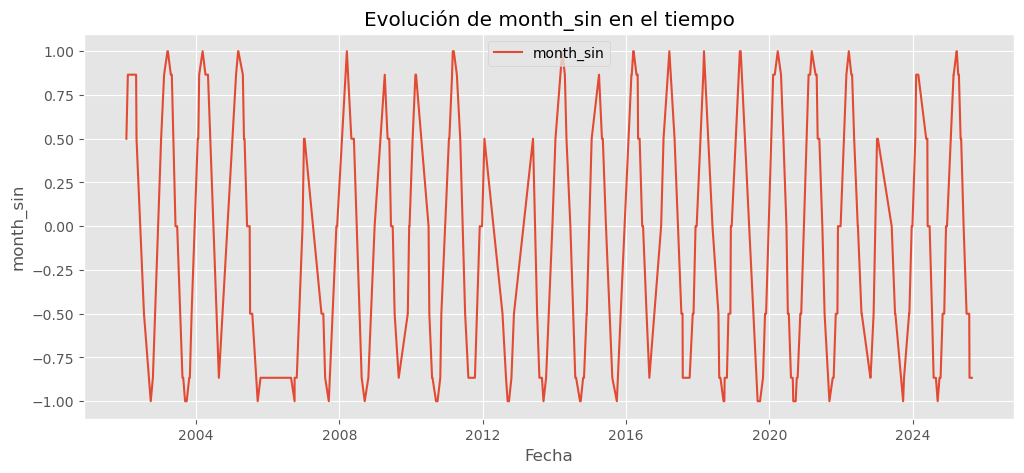

In [135]:

plt.figure(figsize=(12,5))
plt.plot(df['FechaHora'], df['month_sin'], label="month_sin")
plt.xlabel("Fecha")
plt.ylabel("month_sin")
plt.title("Evolución de month_sin en el tiempo")
plt.legend()
plt.show()

### VECTOR DE ENTRADA: X
#### Dejar solo columnas numéricas

In [136]:
# Eliminamos columnas originales que no contienen información numérica
# Se define el vector de entrada

X = df.drop(columns=[datetime_col, 
                      "Evento",
                      "Latitud",
                      "Longitud",
                      "Inten",
                      "Mag",
                      "Tipo_Mag",
                      "Localizacion",
                      "FechaHora",
                      "geometry",
                      "Zona_ID",
                      "month", 
                      "day",
                      "hour", 
                      "dayofweek"]) 

### LECTURA DE DATAFRAME DE SALIDA

In [137]:

# Leer el DataFrame de salida

filename = f"Datos_salida_clases_zona_{zona}.pkl"
output_file=ruta+"/pkl_files/"+filename

df_out = pd.read_pickle(output_file)

df_out.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 485 entries, 0 to 484
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Evento                 485 non-null    object        
 1   Latitud                485 non-null    float64       
 2   Longitud               485 non-null    float64       
 3   Prof_Km                485 non-null    float64       
 4   Inten                  485 non-null    object        
 5   Mag                    485 non-null    float64       
 6   Tipo_Mag               485 non-null    Int64         
 7   Localizacion           485 non-null    object        
 8   FechaHora              485 non-null    datetime64[ns]
 9   Mag_mbLgL              485 non-null    float64       
 10  geometry               485 non-null    geometry      
 11  Zona_ID                485 non-null    float64       
 12  Mmax_next30d           485 non-null    float64       
 1

### VECTOR DE SALIDA: y

In [138]:
y = df_out[class_label]
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 485 entries, 0 to 484
Series name: Class_label_Jenks
Non-Null Count  Dtype
--------------  -----
485 non-null    int64
dtypes: int64(1)
memory usage: 3.9 KB


### VECTORES DE ENTRENAMIENTO Y DE TEST

In [139]:
# Partición train/test

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, stratify=y_trainval, random_state=42
)
print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train: (291, 113) Val: (97, 113) Test: (97, 113)


### PIPELINE DE PREPROCESAMIENTO

In [140]:
# =====================================================
# 1. Custom transformer para log1p en columnas sesgadas
# =====================================================
class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, skew_threshold=1.0):
        self.skew_threshold = skew_threshold
        self.cols_to_log = []

    def fit(self, X, y=None):
        skewness = pd.DataFrame(X).skew()
        self.cols_to_log = skewness[skewness > self.skew_threshold].index.tolist()
        print(f"Columnas con log1p aplicado: {self.cols_to_log}")
        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()
        for col in self.cols_to_log:
            X[col] = np.log1p(np.clip(X[col], a_min=0, a_max=None))  # evitar negativos
        return X

# =====================================================
# 2. Pipeline de preprocesamiento
# =====================================================
def make_preprocessing_pipeline():
    pipeline = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("log_transform", LogTransformer(skew_threshold=1.0)),
        ("scaler", StandardScaler())
    ])
    return pipeline

### PREPROCESAMIENTO

In [141]:
# =====================================================
# 5. Preprocesamiento con pipeline
# =====================================================
pipeline = make_preprocessing_pipeline()

X_train_proc = pipeline.fit_transform(X_train)
X_val_proc   = pipeline.transform(X_val)
X_test_proc  = pipeline.transform(X_test)

# Convertimos de nuevo a DataFrame con nombres
X_train_proc = pd.DataFrame(X_train_proc, columns=X_train.columns, index=X_train.index)
X_val_proc   = pd.DataFrame(X_val_proc,   columns=X_val.columns,   index=X_val.index)
X_test_proc  = pd.DataFrame(X_test_proc,  columns=X_test.columns,  index=X_test.index)

print("Shape tras preprocessing:", X_train_proc.shape)

Columnas con log1p aplicado: [6, 10, 12, 13, 18, 19, 20, 21, 22, 29, 30, 31, 33, 34, 36, 37, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 97]
Shape tras preprocessing: (291, 113)


# MÉTODO LIGHTGBM

### ENTRENAMIENTO

In [142]:
clf = lgb.LGBMClassifier(n_estimators=300, random_state=42)

evals_result = {}

clf.fit(
    X_train_proc, y_train,
    eval_set=[(X_val_proc, y_val)],
    eval_metric=["multi_logloss", "multi_error"],  # <--- añadimos accuracy (multi_error)
    callbacks=[
        lgb.early_stopping(stopping_rounds=20),
        lgb.log_evaluation(50),
        lgb.record_evaluation(evals_result)
    ]
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8460
[LightGBM] [Info] Number of data points in the train set: 291, number of used features: 112
[LightGBM] [Info] Start training from score -1.630272
[LightGBM] [Info] Start training from score -1.068153
[LightGBM] [Info] Start training from score -1.514440
[LightGBM] [Info] Start training from score -1.424828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

LGBMClassifier(n_estimators=300, random_state=42)

### SELECCIÓN DE CARACTERÍSTICAS LIGHT_GBM

In [143]:
# =====================================================
# 6. Selección de características con LightGBM
# =====================================================

clf = lgb.LGBMClassifier(n_estimators=300, random_state=42)

"""
import lightgbm as lgb

# Ejemplo de configuración optimizada para clasificación multiclase
clf = lgb.LGBMClassifier(
    boosting_type="gbdt",      # Gradient Boosted Decision Trees
    objective="multiclass",    # Objetivo multiclase
    num_class=4,               # Nº de clases (cámbialo según tu problema)
    
    # Control de complejidad
    n_estimators=1000,         # Más árboles que el default (100), pero con learning_rate bajo
    learning_rate=0.05,        # Menor que el default (0.1), más preciso y estable
    num_leaves=121,             # Complejidad del árbol (default = 31)
    max_depth=50,              # Sin límite, pero puedes fijar p.ej. 10 para evitar sobreajuste
    
    # Regularización
    min_child_samples=80,      # Default=20, subo para evitar hojas con muy pocos datos
    subsample=0.8,             # Bagging (default=1.0), introduce aleatoriedad
    subsample_freq=1,          # Cada iteración aplica el subsample
    colsample_bytree=0.8,      # Usa solo el 80% de las variables en cada árbol
    reg_alpha=0.1,             # Regularización L1
    reg_lambda=0.1,            # Regularización L2
    
    # Otros
    random_state=42,           # Reproducibilidad
    n_jobs=-1                  # Usa todos los núcleos disponibles
)

"""

evals_result = {}

clf.fit(
    X_train_proc, y_train,
#    eval_set=[(X_val_proc, y_val)],
    eval_set=[(X_train_proc, y_train), (X_val_proc, y_val)],
    eval_metric=["multi_logloss", "multi_error"],  # <--- añadimos accuracy (multi_error)
    callbacks=[
        lgb.early_stopping(stopping_rounds=20),
        lgb.log_evaluation(50),
        lgb.record_evaluation(evals_result)
    ]
)

# Selección automática de features
sfm = SelectFromModel(clf, prefit=True, threshold="median")
X_train_embedded = X_train_proc.loc[:, sfm.get_support()]
X_val_embedded   = X_val_proc.loc[:, sfm.get_support()]
X_test_embedded  = X_test_proc.loc[:, sfm.get_support()]

print("Características seleccionadas:", X_train_embedded.shape[1])


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8460
[LightGBM] [Info] Number of data points in the train set: 291, number of used features: 112
[LightGBM] [Info] Start training from score -1.630272
[LightGBM] [Info] Start training from score -1.068153
[LightGBM] [Info] Start training from score -1.514440
[LightGBM] [Info] Start training from score -1.424828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

### SELECCIÓN DE CARACTERÍSTICAS SHAP

Tipo de shap_values: <class 'numpy.ndarray'>
shap_values.shape: (291, 113, 4)
shap_mean.shape: (4,)
X_for_shap.shape: (291, 113)
Top 20 features seleccionadas: ['M_obs', 'year', 'MagMax_180d', 'MagMax_30d', 'TiempoDesdeUltimo', 'eta_N_lsq', 'db_mlk_8_10', 'TiempoVentana_5Eventos', 'MagMax_90d', 'Ccluster', 'a_lsq', 'Tasa_Benioff', 'Mag_std_30d', 'month_sin', 'Mag_media_30d', 'hour_sin', 'Mdef_Neventos_lsq', 'month_cos', 'Trec_M3.5_lsq', 'eta_N_mlk']


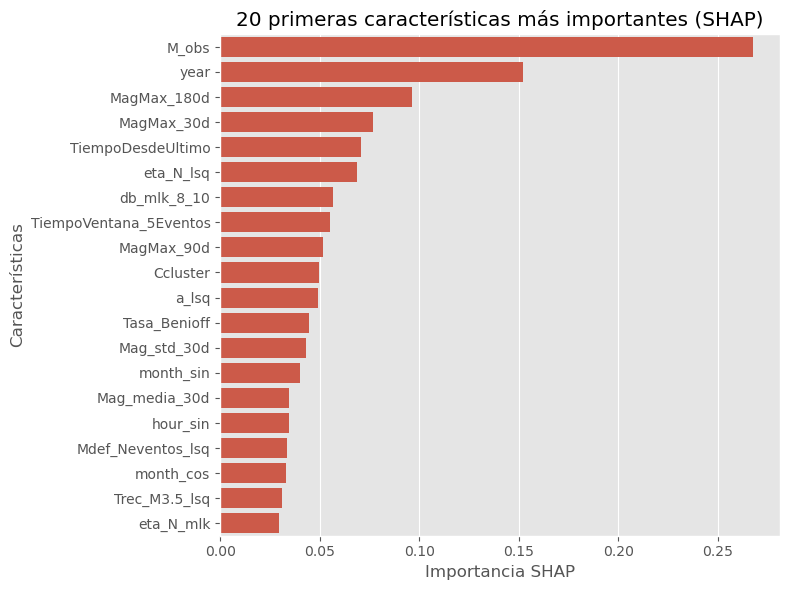

In [144]:
# ============================================
# 2. Calcular SHAP y seleccionar top20
# ============================================
explainer = shap.TreeExplainer(clf)

X_train_shap = X_train_proc.copy()
top_n=20

shap_values = explainer.shap_values(X_train_shap)


## -------------------------
# Calcular shap_values
# -------------------------
shap_values = explainer.shap_values(X_train_shap)  # puede devolver lista o ndarray
print("Tipo de shap_values:", type(shap_values))

# Mostrar formas para depuración
if isinstance(shap_values, list):
    shapes = [np.asarray(s).shape for s in shap_values]
    print("shap_values es lista por clase. shapes por elemento:", shapes)
else:
    print("shap_values.shape:", np.asarray(shap_values).shape)

# -------------------------
# Reducir a vector 1D por feature: shap_mean (n_features,)
# -------------------------
arr = np.asarray(shap_values)

if isinstance(shap_values, list):
    # lista de arrays (una por clase) -> stack a (n_classes, n_samples, n_features) o (n_classes, n_features)
    try:
        stacked = np.stack([np.asarray(s) for s in shap_values])  # shape variable
    except Exception as e:
        raise RuntimeError("No se pudo apilar shap_values (lista). Revisar shapes individuales.") from e

    if stacked.ndim == 3:
        # (n_classes, n_samples, n_features) -> media absoluta sobre clases y muestras
        shap_mean = np.mean(np.abs(stacked), axis=(0,1))   # (n_features,)
    elif stacked.ndim == 2:
        # (n_classes, n_features) -> media absoluta sobre clases
        shap_mean = np.mean(np.abs(stacked), axis=0)      # (n_features,)
    else:
        raise ValueError(f"Forma inesperada tras stack: {stacked.shape}")

else:
    # shap_values es ndarray
    if arr.ndim == 3:
        # (n_classes, n_samples, n_features)
        shap_mean = np.mean(np.abs(arr), axis=(0,1))
    elif arr.ndim == 2:
        # (n_samples, n_features)
        shap_mean = np.mean(np.abs(arr), axis=0)
    else:
        raise ValueError(f"Forma inesperada de shap_values ndarray: {arr.shape}")

shap_mean = np.asarray(shap_mean).flatten()
print("shap_mean.shape:", shap_mean.shape)
print("X_for_shap.shape:", X_train_shap.shape)

# =====================================================
# 1. Calcular SHAP y seleccionar top20
# =====================================================
# shap_values: (n_samples, n_features, n_classes)
shap_mean = np.mean(np.abs(shap_values), axis=(0, 2))  # (n_features,)

df_shap = pd.DataFrame({
    "feature": X_train_shap.columns,
    "shap_importance": shap_mean
}).sort_values("shap_importance", ascending=False).reset_index(drop=True)

top20 = df_shap.head(20)["feature"].tolist()
print("Top 20 features seleccionadas:", top20)

# -------------------------
# Comprobar consistencia con nombres de columnas
# -------------------------
n_feat_shap = shap_mean.shape[0]
n_feat_X = X_train_shap.shape[1]

if n_feat_shap != n_feat_X:
    msg = (
        f"ADVERTENCIA: número de features en SHAP ({n_feat_shap}) != número de columnas en X_for_shap ({n_feat_X}).\n"
        "Esto suele ocurrir si el modelo/SHAP se calculó con otro conjunto/orden de features. "
        "Comprueba que utilizas exactamente las mismas columnas y el mismo preprocesado."
    )
    print(msg)
    # Intentamos crear nombres genéricos si no tenemos match
    feat_names = [f"feat_{i}" for i in range(n_feat_shap)]
else:
    feat_names = list(X_train_shap.columns)
    
# Gráfico
plt.figure(figsize=(8, 6))
sns.barplot(data=df_shap.head(20), x="shap_importance", y="feature")
plt.xlabel("Importancia SHAP")
plt.ylabel("Características")
plt.title("20 primeras características más importantes (SHAP)")
plt.tight_layout()
plt.show()

### CARACTERÍSTICAS SELECCIONADAS (LIGHT_BGM)

In [145]:
# Nombres de las columnas seleccionadas
selected_features = X_train_proc.columns[sfm.get_support()]
print("Features seleccionadas:")
print(selected_features.tolist())

Features seleccionadas:
['Prof_Km', 'Mag_mbLgL', 'a_lsq', 'b_lsq', 'a_mlk', 'Tasa_Benioff', 'Tiempo_50_eventos', 'Mag_media_50', 'Mag_media_30d', 'Mag_std_30d', 'z_30d_eventos', 'M_obs', 'MagMax_30d', 'MagMax_90d', 'MagMax_180d', 'ProfMedia_30d', 'TiempoDesdeUltimo', 'TiempoVentana_5Eventos', 'CoefVar_50Eventos', 'eta_T_lsq', 'eta_T_mlk', 'eta_N_lsq', 'eta_N_mlk', 'sigma_b_mlk_30d', 'sigma_b_lsq_50ev', 'sigma_b_mlk_50ev', 'Mdef_Tdias_lsq', 'Mdef_Tdias_mlk', 'Mdef_Neventos_lsq', 'Mdef_Neventos_mlk', 'Trec_M3.5_lsq', 'db_lsq_0_2', 'db_lsq_2_4', 'db_lsq_4_6', 'db_lsq_6_8', 'db_lsq_8_10', 'db_lsq_0_4', 'db_lsq_8_12', 'db_lsq_12_16', 'db_lsq_16_20', 'db_mlk_0_2', 'db_mlk_2_4', 'db_mlk_4_6', 'db_mlk_6_8', 'db_mlk_8_10', 'db_mlk_0_4', 'db_mlk_4_8', 'db_mlk_8_12', 'db_mlk_12_16', 'db_mlk_16_20', 'Ccluster', 'year', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']


### CARACTERÍSTICAS MÁS IMPORTANTES (LIGHT_GBM)

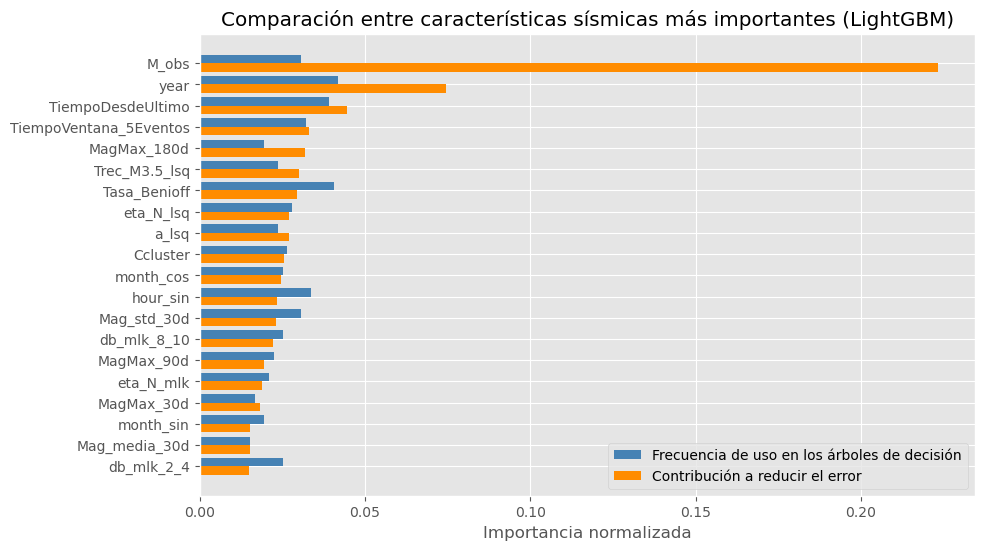

In [146]:

def caracteristicas_top_light_GBM(clf, output_file=None):

    # Obtenemos las importancias
    split_importance = clf.booster_.feature_importance(importance_type='split')
    gain_importance = clf.booster_.feature_importance(importance_type='gain')

    # Creamos un dataframe con ambas métricas
    feat_imp = pd.DataFrame({
        "feature": clf.booster_.feature_name(),
        "split_importance": split_importance,
        "gain_importance": gain_importance
    })

    # Normalizamos para comparar en la misma escala
    feat_imp["split_norm"] = feat_imp["split_importance"] / feat_imp["split_importance"].sum()
    feat_imp["gain_norm"] = feat_imp["gain_importance"] / feat_imp["gain_importance"].sum()

    # Ordenamos por gain para ver las más relevantes
    feat_imp_sorted = feat_imp.sort_values("gain_norm", ascending=False).head(20)

    # Posiciones para las barras
    y = np.arange(len(feat_imp_sorted))
    bar_width = 0.4  

    fig=plt.figure(figsize=(10,6))

    # Barras para split (azul)
    plt.barh(y - bar_width/2, feat_imp_sorted["split_norm"], 
         height=bar_width, color="steelblue", label="Frecuencia de uso en los árboles de decisión")

    # Barras para gain (naranja)
    plt.barh(y + bar_width/2, feat_imp_sorted["gain_norm"], 
         height=bar_width, color="darkorange", label="Contribución a reducir el error")

    # Etiquetas
    plt.yticks(y, feat_imp_sorted["feature"])
    plt.xlabel("Importancia normalizada")
    plt.title("Comparación entre características sísmicas más importantes (LightGBM)")
    plt.legend()
    plt.gca().invert_yaxis()  # Para que la más importante quede arriba

    

    if output_file:
        fig.savefig(f"{output_file}.pdf", bbox_inches='tight')
        fig.savefig(f"{output_file}.png", bbox_inches='tight', dpi=300)

    plt.show()


filename = f"Caracteristicas_importantes_LightGBM_{class_label}_zona_{zona}"
output_file=ruta+"/figuras/"+filename

caracteristicas_top_light_GBM(clf, output_file=None)

In [147]:
# Importancia de las 20 principales variables seleccionadas por LightGBM

# La métrica Gain refleja la contribución a la reducción de la pérdida
# Split indica la frecuencia de uso de la variable en las divisiones del modelo.")


# Importancias desde el booster interno
gain_importances = clf.booster_.feature_importance(importance_type='gain')
split_importances = clf.booster_.feature_importance(importance_type='split')
features = clf.booster_.feature_name()

# Construir DataFrame
feat_imp = pd.DataFrame({
    'Variable': features,
    'Gain': gain_importances,
    'Split': split_importances
})

# Normalización a porcentajes
feat_imp['Gain (%)'] = 100 * feat_imp['Gain'] / feat_imp['Gain'].sum()
feat_imp['Split (%)'] = 100 * feat_imp['Split'] / feat_imp['Split'].sum()

# Ordenar por importancia (Gain) y seleccionar top 20
feat_imp_sorted = feat_imp.sort_values(by="Gain (%)", ascending=False).head(20)

# Exportar a tabla tipo APA (sin tabulate)
table_txt = feat_imp_sorted[['Variable', 'Gain (%)', 'Split (%)']].to_string(
    index=False, float_format="%.2f"
)

print("=== Tabla APA (Texto plano) ===")
print(table_txt)


=== Tabla APA (Texto plano) ===
              Variable  Gain (%)  Split (%)
                 M_obs     22.32       3.08
                  year      7.46       4.20
     TiempoDesdeUltimo      4.44       3.92
TiempoVentana_5Eventos      3.32       3.22
           MagMax_180d      3.17       1.96
         Trec_M3.5_lsq      3.00       2.38
          Tasa_Benioff      2.96       4.06
             eta_N_lsq      2.71       2.80
                 a_lsq      2.70       2.38
              Ccluster      2.56       2.66
             month_cos      2.47       2.52
              hour_sin      2.34       3.36
           Mag_std_30d      2.30       3.08
           db_mlk_8_10      2.21       2.52
            MagMax_90d      1.95       2.24
             eta_N_mlk      1.88       2.10
            MagMax_30d      1.83       1.68
             month_sin      1.52       1.96
         Mag_media_30d      1.51       1.54
            db_mlk_2_4      1.48       2.52


### CARACTERÍSTICAS COMUNES SHAP + LIGHT_BGM

In [148]:
top20_shap = df_shap.head(20)["feature"].tolist()
top20_gain=feat_imp_sorted['Variable'].copy()

print(top20_shap)
print(top20_gain)

# =====================================================
# 5. Selección híbrida
# =====================================================
# Coincidencias (robustas)
common_features = list(set(top20_gain) & set(top20_shap))

# Exclusivas (para no perder info)
unique_gain = [f for f in top20_gain if f not in common_features][:5]
unique_shap = [f for f in top20_shap if f not in common_features][:5]

# Vector final de selección
selected_features = common_features + unique_gain + unique_shap

print("=== Selección de variables híbrida ===")
print(f"Comunes (robustas): {len(common_features)} -> {common_features}")
print(f"Únicas Gain: {unique_gain}")
print(f"Únicas SHAP: {unique_shap}")
print(f"Total seleccionadas: {len(selected_features)}")



['M_obs', 'year', 'MagMax_180d', 'MagMax_30d', 'TiempoDesdeUltimo', 'eta_N_lsq', 'db_mlk_8_10', 'TiempoVentana_5Eventos', 'MagMax_90d', 'Ccluster', 'a_lsq', 'Tasa_Benioff', 'Mag_std_30d', 'month_sin', 'Mag_media_30d', 'hour_sin', 'Mdef_Neventos_lsq', 'month_cos', 'Trec_M3.5_lsq', 'eta_N_mlk']
12                      M_obs
106                      year
18          TiempoDesdeUltimo
19     TiempoVentana_5Eventos
16                MagMax_180d
43              Trec_M3.5_lsq
6                Tasa_Benioff
31                  eta_N_lsq
2                       a_lsq
105                  Ccluster
108                 month_cos
109                  hour_sin
10                Mag_std_30d
99                db_mlk_8_10
15                 MagMax_90d
32                  eta_N_mlk
14                 MagMax_30d
107                 month_sin
9               Mag_media_30d
96                 db_mlk_2_4
Name: Variable, dtype: object
=== Selección de variables híbrida ===
Comunes (robustas): 19 -> ['Mag_media

# MÉTODO TRANSFORMER

### TENSORES DE PYTORCH

In [149]:
# ===============================
# 1. Conversión a tensores
# ===============================

# Usamos los datasets reducidos (25 características)
X_train_reduced = X_train_proc[selected_features]
X_val_reduced   = X_val_proc[selected_features]
X_test_reduced  = X_test_proc[selected_features]

X_train_t = torch.tensor(X_train_reduced.values, dtype=torch.float32) #.unsqueeze(-1)
y_train_t = torch.tensor(y_train.values, dtype=torch.long)

X_val_t   = torch.tensor(X_val_reduced.values, dtype=torch.float32) #.unsqueeze(-1)
y_val_t   = torch.tensor(y_val.values, dtype=torch.long)

X_test_t  = torch.tensor(X_test_reduced.values, dtype=torch.float32) #.unsqueeze(-1)
y_test_t  = torch.tensor(y_test.values, dtype=torch.long)



print("Shapes:")
print("Train:", X_train_t.shape, y_train_t.shape)
print("Val:  ", X_val_t.shape, y_val_t.shape)
print("Test: ", X_test_t.shape, y_test_t.shape)

Shapes:
Train: torch.Size([291, 21]) torch.Size([291])
Val:   torch.Size([97, 21]) torch.Size([97])
Test:  torch.Size([97, 21]) torch.Size([97])


### MODELO TRANSFORMER

In [150]:
import torch
import torch.nn as nn

class TransformerModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embedding = nn.Linear(len(selected_features), config["embed_dim"])
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=config["embed_dim"],
            nhead=config["num_heads"],
            dim_feedforward=config["ff_dim"],
            dropout=config["dropout"],
            activation="relu",
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=config["num_layers"])
        self.fc = nn.Linear(config["embed_dim"], config["num_classes"])
        self.dropout = nn.Dropout(config["dropout"])

    def forward(self, x):
        # x: (batch, 24)
        x = self.embedding(x)         # (batch, embed_dim)
        #x = x.unsqueeze(1)            # (batch, 1, embed_dim)
        out = self.transformer(x)     # (batch, 1, embed_dim)
        out = out.squeeze(1)          # (batch, embed_dim)
        out = self.dropout(out)
        return self.fc(out)

    


In [151]:
"""
# =============================
# Definición del Transformer
# =============================
class TransformerModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embedding = nn.Linear(1, config["embed_dim"])  # cada feature → embedding
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=config["embed_dim"],
            nhead=config["num_heads"],
            dim_feedforward=config["ff_dim"],
            dropout=config["dropout"],
            activation="relu",
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=config["num_layers"])
        self.dropout = nn.Dropout(config["dropout"])
        self.fc = nn.Linear(config["embed_dim"], config["num_classes"])

    def forward(self, x):
        # x: (batch, seq_len, 1)
        x = self.embedding(x)              # (batch, seq_len, embed_dim)
        out = self.transformer(x)          # (batch, seq_len, embed_dim)
        out = out.mean(dim=1)              # media sobre secuencia
        out = self.dropout(out)
        return self.fc(out)

"""

'\n# =============================\n# Definición del Transformer\n# =============================\nclass TransformerModel(nn.Module):\n    def __init__(self, config):\n        super().__init__()\n        self.embedding = nn.Linear(1, config["embed_dim"])  # cada feature → embedding\n        encoder_layer = nn.TransformerEncoderLayer(\n            d_model=config["embed_dim"],\n            nhead=config["num_heads"],\n            dim_feedforward=config["ff_dim"],\n            dropout=config["dropout"],\n            activation="relu",\n            batch_first=True\n        )\n        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=config["num_layers"])\n        self.dropout = nn.Dropout(config["dropout"])\n        self.fc = nn.Linear(config["embed_dim"], config["num_classes"])\n\n    def forward(self, x):\n        # x: (batch, seq_len, 1)\n        x = self.embedding(x)              # (batch, seq_len, embed_dim)\n        out = self.transformer(x)          # (batch, seq_le

In [152]:
# =============================
# Datasets y DataLoaders
# =============================
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset   = TensorDataset(X_val_t, y_val_t)



In [153]:
"""
# Configuración 
config = {
    "num_features": len(selected_features),   # después de LightGBM + SHAP
    "embed_dim": 64,
    "num_heads": 4,
    "ff_dim": 128,
    "num_layers": 2,
    "dropout": 0.2,
    "num_classes": 4      # o el número de clases que tengas
}
"""

'\n# Configuración \nconfig = {\n    "num_features": len(selected_features),   # después de LightGBM + SHAP\n    "embed_dim": 64,\n    "num_heads": 4,\n    "ff_dim": 128,\n    "num_layers": 2,\n    "dropout": 0.2,\n    "num_classes": 4      # o el número de clases que tengas\n}\n'

### ENTRENAMIENTO

In [154]:
# =============================
# Función de entrenamiento
# =============================
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            pred_labels = preds.argmax(1)
            correct += (pred_labels == yb).sum().item()
            total += yb.size(0)
    return correct / total


### Ejecución con Optuna

In [155]:
# =============================
# Función objetivo para Optuna
# =============================
def objective(trial):
    config = {       
        "num_features": len(selected_features),
        "num_layers": trial.suggest_int("num_layers", 1, 4),
        "num_heads": trial.suggest_categorical("num_heads", [2, 4, 8, 16]),
        "embed_dim": trial.suggest_categorical("embed_dim", [16, 32, 64, 128]),
        "ff_dim": trial.suggest_categorical("ff_dim", [64, 128, 256, 512,1024]),
        "dropout": trial.suggest_float("dropout", 0.3, 0.7, step=0.1),
        "weight_decay": trial.suggest_loguniform("weight_decay", 1e-7, 1e-3),
        "lr": trial.suggest_loguniform("lr", 1e-5, 1e-2),
        "batch_size": trial.suggest_categorical("batch_size", [16, 32, 64, 128]),
        "epochs": 30,
        "input_dim": X_train_t.shape[-1],
        "num_classes": len(torch.unique(y_train_t))
    }

    """
        # Valores por defecto
        "num_layers": trial.suggest_int("num_layers", 1, 4),
        "num_heads": trial.suggest_categorical("num_heads", [2, 4, 8]),
        "embed_dim": trial.suggest_categorical("embed_dim", [16, 32, 64, 128]),
        "ff_dim": trial.suggest_categorical("ff_dim", [64, 128, 256, 512]),
        "dropout": trial.suggest_float("dropout", 0.1, 0.5, step=0.1),
        "weight_decay": trial.suggest_loguniform("weight_decay", 1e-6, 1e-3),
        "lr": trial.suggest_loguniform("lr", 1e-5, 1e-2),
        "batch_size": trial.suggest_categorical("batch_size", [32, 64, 128]),
        "epochs": 20,
        "input_dim": X_train_t.shape[-1],
        "num_classes": len(torch.unique(y_train_t))
    """

    
    """
    Mejores hiperparámetros: {'num_layers': 3, 'num_heads': 4, 'embed_dim': 64, 
                          'ff_dim': 512, 'dropout': 0.5, 'weight_decay': 1.6981048113136527e-05, 
                          'lr': 0.0002552265040757819, 'batch_size': 32, 
                          'input_dim': 1, 'num_classes': 4}

    Mejores hiperparámetros: {'num_layers': 1, 'num_heads': 2, 'embed_dim': 32, 
                          'ff_dim': 128, 'dropout': 0.5, 'weight_decay': 3.816283618994787e-05, 
                          'lr': 0.0011211211678068605, 'batch_size': 32, 
                          'input_dim': 1, 'num_classes': 4}

    """ 
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TransformerModel(config).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])
    criterion = nn.CrossEntropyLoss()

    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)

    best_val_acc = 0
    for epoch in range(config["epochs"]):
        train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_acc = evaluate(model, val_loader, device)
        best_val_acc = max(best_val_acc, val_acc)

    return best_val_acc  # lo que optimizamos

In [156]:
# =====================================================
# Crear y ejecutar estudio Optuna con SQLite
# =====================================================
study = optuna.create_study(
    direction="maximize",
    study_name = f"Transformer_best_config_{class_label}_zona_{zona}",
    storage="sqlite:///optuna_study.db",
    load_if_exists=True
)

study.optimize(objective, n_trials=15)

[I 2025-10-03 13:27:18,636] A new study created in RDB with name: Transformer_best_config_Class_label_Jenks_zona_39
/var/folders/sw/ns8_83yx1sgg06xbf6tp3n640000gn/T/ipykernel_63283/3225883181.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "weight_decay": trial.suggest_loguniform("weight_decay", 1e-7, 1e-3),
/var/folders/sw/ns8_83yx1sgg06xbf6tp3n640000gn/T/ipykernel_63283/3225883181.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lr": trial.suggest_loguniform("lr", 1e-5, 1e-2),
[I 2025-10-03 13:27:19,219] Trial 0 finished with value: 0.5567010309278351 and parameters: {'num_layers': 1, 'num_heads': 16, 'embed_dim': 64, 'ff_dim': 512, 'dropout': 0.5, 'weight_d

In [157]:
# =====================================================
# Guardar mejor configuración en JSON
# =====================================================
best_config = study.best_params
best_config["input_dim"] = X_train_t.shape[-1]
best_config["num_classes"] = len(torch.unique(y_train_t))

with open("best_config.json", "w") as f:
    json.dump(best_config, f, indent=4)

print("Mejores parámetros guardados en best_config.json")

print("📌 Mejores hiperparámetros:", best_config)

Mejores parámetros guardados en best_config.json
📌 Mejores hiperparámetros: {'num_layers': 2, 'num_heads': 8, 'embed_dim': 64, 'ff_dim': 1024, 'dropout': 0.4, 'weight_decay': 0.0007447057763529626, 'lr': 0.00224985518763492, 'batch_size': 32, 'input_dim': 21, 'num_classes': 4}


### MOSTRAR RESULTADOS 

/var/folders/sw/ns8_83yx1sgg06xbf6tp3n640000gn/T/ipykernel_63283/1231670317.py:23: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig1 = plot_optimization_history(study)
/var/folders/sw/ns8_83yx1sgg06xbf6tp3n640000gn/T/ipykernel_63283/1231670317.py:24: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  fig2 = plot_param_importances(study)
/var/folders/sw/ns8_83yx1sgg06xbf6tp3n640000gn/T/ipykernel_63283/1231670317.py:25: ExperimentalWarning: optuna.visualization.matplotlib._parallel_coordinate.plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  fig3 = plot_parallel_coordinate(study)


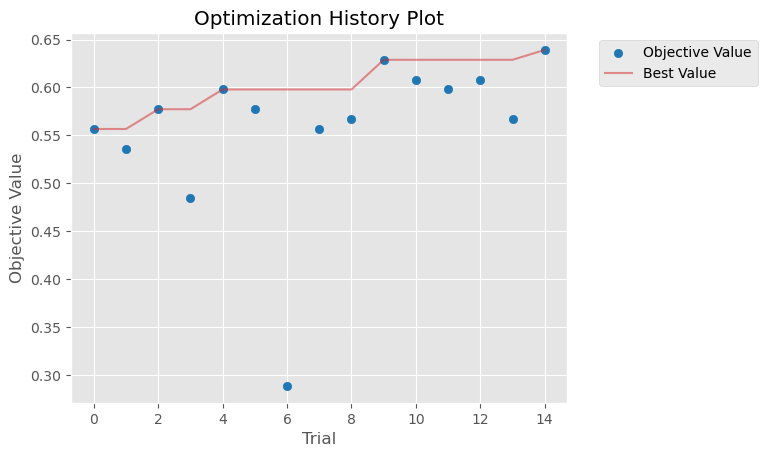

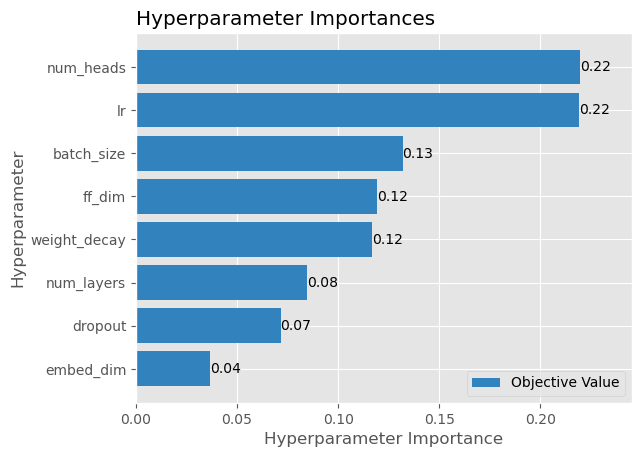

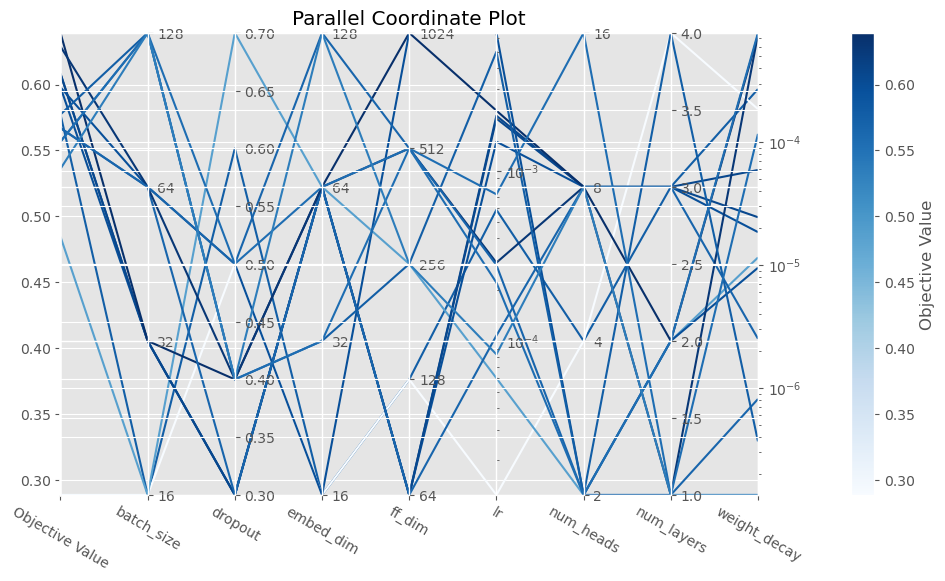

In [158]:
import matplotlib.pyplot as plt
from optuna.visualization.matplotlib import (
    plot_optimization_history,
    plot_param_importances,
    plot_parallel_coordinate
)

# =====================================================
# 1. Cargar el estudio guardado
# =====================================================

study_name = f"Transformer_best_config_{class_label}_zona_{zona}"
storage_url = "sqlite:///optuna_study.db"

study = optuna.load_study(
    study_name=study_name,
    storage=storage_url
)

# =====================================================
# 2. Visualizaciones
# =====================================================
fig1 = plot_optimization_history(study)
fig2 = plot_param_importances(study)
fig3 = plot_parallel_coordinate(study)

# =====================================================
# 3. Guardar figuras
# =====================================================
# --- Figura 1 ---
filename = f"Historico_optimizacion_Transformer_{class_label}_zona_{zona}"
output_file = ruta + "/figuras/" + filename
fig1.get_figure().savefig(f"{output_file}.pdf", bbox_inches='tight')
fig1.get_figure().savefig(f"{output_file}.png", bbox_inches='tight', dpi=300)

# --- Figura 2 ---
filename = f"Hiperparametros_Transformer_{class_label}_zona_{zona}"
output_file = ruta + "/figuras/" + filename
fig2.get_figure().savefig(f"{output_file}.pdf", bbox_inches='tight')
fig2.get_figure().savefig(f"{output_file}.png", bbox_inches='tight', dpi=300)

# --- Figura 3 ---
filename = f"Coordinate_plot_Transformer_{class_label}_zona_{zona}"
output_file = ruta + "/figuras/" + filename
fig3.get_figure().set_size_inches(12, 6)  # ancho=12, alto=6
fig3.get_figure().savefig(f"{output_file}.pdf", bbox_inches='tight')
fig3.get_figure().savefig(f"{output_file}.png", bbox_inches='tight', dpi=300)

# =====================================================
# 4. Mostrar figuras en pantalla
# =====================================================
plt.show()


### ENTRENAR CON MEJOR MODELO

In [159]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Suponiendo que ya tienes:
# X_train, y_train, X_val, y_val, X_test, y_test (numpy arrays o tensores)
# best_params = study.best_params

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Crear modelo con la mejor config
model = TransformerModel(best_config).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_config.get("lr", 1e-3))

# Convertir DataFrames a numpy
X_train_np = X_train_reduced.values.astype("float32")
X_val_np   = X_val_reduced.values.astype("float32")
X_test_np  = X_test_reduced.values.astype("float32")

y_train_np = y_train.values.astype("int64")
y_val_np   = y_val.values.astype("int64")
y_test_np  = y_test.values.astype("int64")

# Crear datasets
train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(X_train_np),
    torch.tensor(y_train_np)
)
val_dataset = torch.utils.data.TensorDataset(
    torch.tensor(X_val_np),
    torch.tensor(y_val_np)
)
test_dataset = torch.utils.data.TensorDataset(
    torch.tensor(X_test_np),
    torch.tensor(y_test_np)
)



# Loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=best_config.get("batch_size", 32), shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=best_config.get("batch_size", 32))
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=best_config.get("batch_size", 32))



### ENTRENAMIENTO

In [160]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, n = 0, 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            total_loss += loss.item()
            correct += (preds.argmax(1) == yb).sum().item()
            n += len(yb)
    return total_loss / len(loader), correct / n

# Entrenamiento principal
best_val_acc = 0
for epoch in range(best_config.get("epochs", 1000)):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_transformer.pth")


Epoch 20: train_loss=0.4492, val_loss=0.9733, val_acc=0.6289
Epoch 40: train_loss=0.3008, val_loss=1.3442, val_acc=0.5670
Epoch 60: train_loss=0.5277, val_loss=1.4393, val_acc=0.5670
Epoch 80: train_loss=0.4306, val_loss=1.3533, val_acc=0.5876
Epoch 100: train_loss=0.2050, val_loss=1.5224, val_acc=0.5567
Epoch 120: train_loss=0.3529, val_loss=1.6388, val_acc=0.5876
Epoch 140: train_loss=0.2278, val_loss=2.7095, val_acc=0.5464
Epoch 160: train_loss=0.1719, val_loss=1.5790, val_acc=0.5979
Epoch 180: train_loss=0.1758, val_loss=1.7662, val_acc=0.6186
Epoch 200: train_loss=0.2776, val_loss=1.8761, val_acc=0.5567
Epoch 220: train_loss=0.1985, val_loss=3.0866, val_acc=0.5464
Epoch 240: train_loss=0.1744, val_loss=1.8768, val_acc=0.5567
Epoch 260: train_loss=0.1655, val_loss=1.9636, val_acc=0.5773
Epoch 280: train_loss=0.4678, val_loss=2.2743, val_acc=0.5773
Epoch 300: train_loss=0.2053, val_loss=1.7354, val_acc=0.5567
Epoch 320: train_loss=0.1216, val_loss=2.0795, val_acc=0.5361
Epoch 340: t

### EVALUACIÓN DE TEST

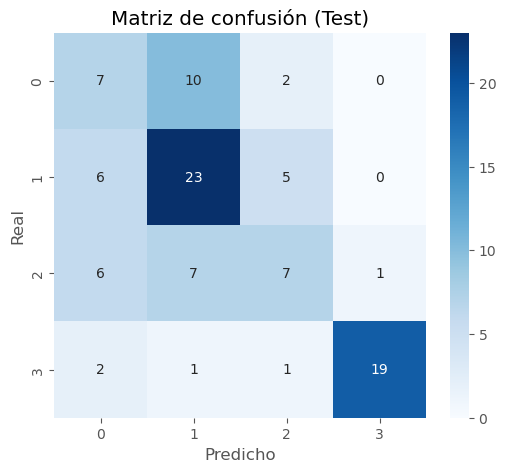

              precision    recall  f1-score   support
0              0.333333  0.368421  0.350000  19.00000
1              0.560976  0.676471  0.613333  34.00000
2              0.466667  0.333333  0.388889  21.00000
3              0.950000  0.826087  0.883721  23.00000
accuracy       0.577320  0.577320  0.577320   0.57732
macro avg      0.577744  0.551078  0.558986  97.00000
weighted avg   0.588211  0.577320  0.577274  97.00000


In [161]:
# Cargar el mejor modelo
model.load_state_dict(torch.load("best_transformer.pth"))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true.extend(yb.cpu().numpy())
        y_pred.extend(preds.argmax(1).cpu().numpy())

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
fig=plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de confusión (Test)")

filename = f"Matriz_confusion_Transformer_{class_label}_zona_{zona}"
output_file=ruta+"/figuras/"+filename

fig.savefig(f"{output_file}.pdf", bbox_inches='tight')
fig.savefig(f"{output_file}.png", bbox_inches='tight', dpi=300)
        
plt.show()

# Informe de clasificación
report = classification_report(y_true, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print(df_report)

In [162]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np
import torch

# ============================
# Evaluar en TEST
# ============================
model.eval()
all_preds, all_true = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_true.extend(y_batch.cpu().numpy())

all_preds = np.array(all_preds)
all_true = np.array(all_true)

# ============================
# Matriz de confusión
# ============================
cm = confusion_matrix(all_true, all_preds)
#print("Matriz de confusión:")
#print(cm)

# ============================
# Función de métricas
# ============================
def compute_metrics(cm):
    metrics = []
    n_classes = cm.shape[0]
    for i in range(n_classes):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FN + FP)

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0  # sensibilidad
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

        metrics.append({
            "Clase": i,
            "Precisión": round(precision, 3),
            "Sensibilidad": round(recall, 3),
            "Especificidad": round(specificity, 3),
            "F1": round(f1, 3)
        })

    # Promedios macro
    df = pd.DataFrame(metrics)
    avg_row = {
        "Clase": "Promedio",
        "Precisión": round(df["Precisión"].mean(), 3),
        "Sensibilidad": round(df["Sensibilidad"].mean(), 3),
        "Especificidad": round(df["Especificidad"].mean(), 3),
        "F1": round(df["F1"].mean(), 3)
    }
    df = pd.concat([df, pd.DataFrame([avg_row])], ignore_index=True)
    return df

# ============================
# Tabla final
# ============================
#df_metrics = compute_metrics(cm)
#print("\nMétricas finales (igual que con LightGBM):")
#print(df_metrics)

# ============================
# Reporte sklearn adicional
# ============================
#print("\nReporte sklearn:")
#print(classification_report(all_true, all_preds, digits=3))


In [163]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score
import pandas as pd
import numpy as np

def classification_report_with_specificity(y_true, y_pred, labels=None):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    n_classes = cm.shape[0]

    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, labels=labels, zero_division=0
    )

    specificity = []
    for i in range(n_classes):
        TN = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        FP = cm[:, i].sum() - cm[i, i]
        spec = TN / (TN + FP) if (TN + FP) > 0 else 0.0
        specificity.append(spec)

    # DataFrame por clase
    report = pd.DataFrame({
        "precision": precision,
        "recall": recall,
        "f1-score": f1,
        "support": support,
        "specificity": specificity
    })

    # Accuracy global
    acc = accuracy_score(y_true, y_pred)
    acc_row = pd.Series({
        "precision": acc,
        "recall": acc,
        "f1-score": acc,
        "support": acc,
        "specificity": acc
    }, name="accuracy")

    # Promedios macro
    macro = report[["precision", "recall", "f1-score", "specificity"]].mean()
    macro["support"] = support.sum()
    macro_row = pd.Series(macro, name="macro avg")

    # Promedios weighted
    weights = support / support.sum()
    weighted = (report[["precision", "recall", "f1-score", "specificity"]].T * weights).T.sum()
    weighted["support"] = support.sum()
    weighted_row = pd.Series(weighted, name="weighted avg")

    # Concatenar todo
    report = pd.concat([report, acc_row.to_frame().T, macro_row.to_frame().T, weighted_row.to_frame().T])
    return report


# ============================
# Uso con tu modelo Transformer
# ============================
df_report = classification_report_with_specificity(all_true, all_preds)
print("===== Reporte con Specificity: Transformer =====")
print(df_report)


===== Reporte con Specificity: Transformer =====
              precision    recall  f1-score   support  specificity
0              0.333333  0.368421  0.350000  19.00000     0.820513
1              0.560976  0.676471  0.613333  34.00000     0.714286
2              0.466667  0.333333  0.388889  21.00000     0.894737
3              0.950000  0.826087  0.883721  23.00000     0.986486
accuracy       0.577320  0.577320  0.577320   0.57732     0.577320
macro avg      0.577744  0.551078  0.558986  97.00000     0.854005
weighted avg   0.588211  0.577320  0.577274  97.00000     0.838702
